In [36]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import os

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [42]:
# load dataset
cwd = os.getcwd()
data = read_csv(os.path.join('../data/rides/')+'rides_count.csv', usecols=[0,1,2,3], parse_dates = [0], infer_datetime_format = True, index_col=0)
data = data.groupby(data.index).agg('sum')
data['total'] = data['un_rides']+data['male_rides']+data['female_rides']
data.index.names = ['Date']
data = data.asfreq('D', fill_value=0)
series = data['total']

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
idx = -200
train, test = supervised_values[0:idx], supervised_values[idx:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

Epoch 1/1
1169/1169 [==============================] - 4s - loss: 0.0481     
Epoch 1/1
1169/1169 [==============================] - 3s - loss: 0.0463     
Epoch 1/1
1169/1169 [==============================] - 3s - loss: 0.0456     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0451     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0450     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0449     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0448     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0448     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0447     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0447     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0447     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0447     
Epoch 1/1
1169/1169 [==============================] - 2s - loss

1169/1169 [==============================] - 2s - loss: 0.0439     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0439     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0439     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0441     
Epoch 1/1
1169/1169 [==============================] - 3s - loss: 0.0442     
Epoch 1/1
1169/1169 [==============================] - 3s - loss: 0.0450     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0471     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0566     - ETA: 0s - loss: 0.
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0509     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0499     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0490     
Epoch 1/1
1169/1169 [==============================] - 2s - loss: 0.0489     
Epoch 1/1
1169/1169 [==============================] -

Day=196, Predicted=25545.093245, Expected=26727.000000
Day=197, Predicted=29631.950101, Expected=21960.000000
Day=198, Predicted=25281.991270, Expected=43056.000000
Day=199, Predicted=41087.911767, Expected=40368.000000
Day=200, Predicted=39233.305004, Expected=7108.000000
Test RMSE: 11236.177


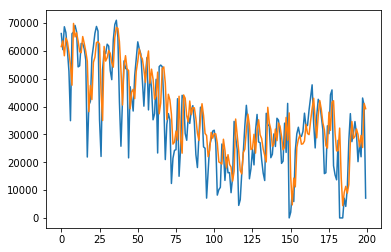

In [44]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 130, 8)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[idx:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[idx:])
pyplot.plot(predictions)
pyplot.show()

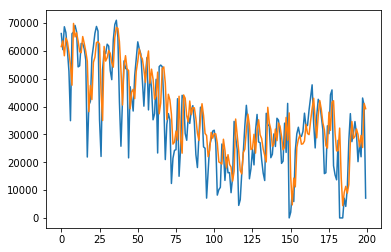

In [45]:
pyplot.plot(raw_values[idx:])
pyplot.plot(predictions)
pyplot.show()